## kmodes

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from kmodes.kmodes import KModes
import mysql.connector #conexión con MySQL

## Preparación de datos

Conexión con MySQL

In [64]:
try:
    conexion = mysql.connector.connect(
        host="localhost",
        user="root",
        password="88121356320",
        database="TFM"
    )
    cursor = conexion.cursor()

    cursor.execute("SELECT * FROM engrana_ok")
    resultados = cursor.fetchall()
    columnas = [descripcion[0] for descripcion in cursor.description] # Obtener los nombres de las columnas

    engrana = pd.DataFrame(resultados, columns=columnas) # Crear el DataFrame

    print(engrana) # Imprimir el DataFrame

except mysql.connector.Error as error:
    print("Error al conectar a la base de datos:", error)

finally:
    if conexion and conexion.is_connected():
        cursor.close()
        conexion.close()
        print("La conexión a la base de datos está cerrada")

          cedula                  nombre_completo base servicio  \
0     1123633555         JEREMY WILLIAMS TELEFORD  ADZ       AT   
1     1017241905     NANCY LUCIA CEBALLOS GIRALDO  ADM       SV   
2     1143386831      GRACE PAOLA CARVAJAL PUELLO  CTG       SV   
3     1041892061      ANGEL DAVID SARMIENTO CALVO  BAQ       SV   
4       39450854          CLAUDIA DINENSY ESCOBAR  MDE       SV   
...          ...                              ...  ...      ...   
5098  1007713726           ANDRES GUZMAN FUENTES   SMR       AT   
5099  1082472284             MAURO HOSTIA FLOREZ   SMR       AT   
5100  1004377626       YAN JAVID OLIVERO RETAMOZO  SMR       AT   
5101  1083022939     JAINER ENRIQUE GOMEZ PINEDO   SMR       AT   
5102    57290209  MARGELYS MILADYS MARTINEZ GOMEZ  SMR       SV   

                           grado_cargo fecha_fin_entrenamiento  \
0     AUXILIAR DE ASISTENCIA EN TIERRA                    None   
1        AGENTE DE SOPORTE OPERACIONAL                    None 

In [65]:
engrana.head()

,cedula,nombre_completo,base,servicio,grado_cargo,fecha_fin_entrenamiento,polivalencia_pax
0,1123633555,JEREMY WILLIAMS TELEFORD,ADZ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,None,VIVA AIR;#LATAM;#COPA
1,1017241905,NANCY LUCIA CEBALLOS GIRALDO,ADM,SV,AGENTE DE SOPORTE OPERACIONAL,None,None
2,1143386831,GRACE PAOLA CARVAJAL PUELLO,CTG,SV,AUXILIAR DE SERVICIOS,None,None
3,1041892061,ANGEL DAVID SARMIENTO CALVO,BAQ,SV,AUXILIAR DE SERVICIOS,None,None
4,39450854,CLAUDIA DINENSY ESCOBAR,MDE,SV,AUXILIAR DE SERVICIOS,None,None


In [66]:
engrana['polivalencia_pax'] = engrana['polivalencia_pax'].str.strip().str.upper() # Se normaliza la columna y se eliminan los espacios en blanco
engrana['base'] = engrana['base'].str.strip().str.upper() # Se normaliza la columna y se eliminan los espacios en blanco
engrana['grado_cargo'] = engrana['grado_cargo'].str.strip().str.upper() # Se normaliza la columna y se eliminan los espacios en blanco

In [67]:
engrana_nulos = engrana.isnull().sum()
print(engrana_nulos)

cedula                        0
nombre_completo               0
base                          0
servicio                      0
grado_cargo                   0
fecha_fin_entrenamiento     848
polivalencia_pax           3039
dtype: int64


In [68]:
resultados = engrana.groupby('polivalencia_pax')['servicio'].value_counts().unstack()
print(resultados)

servicio                                              AT      SV
polivalencia_pax                                                
AEROLINEAS ARGENTINAS                                NaN    11.0
AEROMEXICO                                           NaN     8.0
ARAJET                                               NaN    19.0
AVIANCA                                              NaN    28.0
AVIANCA EXPRESS                                      NaN     3.0
AVIANCA;#AVIANCA EXPRESS;#COPA;#JETSMART;#LATAM...  60.0     NaN
AVIANCA;#VIVA AIR                                    NaN     1.0
COPA                                                 NaN   262.0
COPA;#VIVA AIR                                       NaN    44.0
JETSMART                                             NaN   158.0
JETSMART;#VIVA AIR                                   NaN     1.0
LATAM                                                NaN   236.0
LATAM;#VIVA AIR                                      NaN     9.0
LATAM;#WINGO             

Hay muchos casos de areolineas combinadas, para eso vamos a cambiar el nombre en estos casos, por el generico "multiaerolinea"

In [69]:
aerolineas_a_reemplazar = ['AVIANCA;#AVIANCA EXPRESS;#COPA;#JETSMART;#LATAM;#VIVA AIR;#WINGO', 'AVIANCA;#VIVA AIR', 'COPA;#VIVA AIR', 'JETSMART;#VIVA AIR', 'LATAM;#VIVA AIR', 'LATAM;#WINGO', 'VIVA AIR;#AVIANCA', 'VIVA AIR;#COPA', 'VIVA AIR;#JETSMART', 'VIVA AIR;#JETSMART;#VIVA AEROBUS','VIVA AIR;#LATAM', 'VIVA AIR;#LATAM;#COPA', 'VIVA AIR;#WINGO', 'WINGO;#VIVA AIR']
engrana['polivalencia_pax'] = engrana['polivalencia_pax'].replace(aerolineas_a_reemplazar, 'MULTIAEROLINEA')

Se puede observar que todos los casos nulos están asociados asociados al serivicio AT, por lo tanto podemos imputarlos a esa clasificación sin alterar las metricas

In [70]:
engrana['polivalencia_pax'] = engrana['polivalencia_pax'].fillna('MULTIAEROLINEA') # Reemplazar valores nulos con 'MULTIAEROLINEA'

In [71]:
resultados = engrana.groupby('polivalencia_pax')['servicio'].value_counts().unstack()
print(resultados)

servicio                   AT      SV
polivalencia_pax                     
AEROLINEAS ARGENTINAS     NaN    11.0
AEROMEXICO                NaN     8.0
ARAJET                    NaN    19.0
AVIANCA                   NaN    28.0
AVIANCA EXPRESS           NaN     3.0
COPA                      NaN   262.0
JETSMART                  NaN   158.0
LATAM                     NaN   236.0
MULTIAEROLINEA         2964.0   318.0
SARPA                     NaN     9.0
VIVA AIR                  1.0  1059.0
WINGO                     NaN    27.0


In [72]:
engrana.head()

,cedula,nombre_completo,base,servicio,grado_cargo,fecha_fin_entrenamiento,polivalencia_pax
0,1123633555,JEREMY WILLIAMS TELEFORD,ADZ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,None,MULTIAEROLINEA
1,1017241905,NANCY LUCIA CEBALLOS GIRALDO,ADM,SV,AGENTE DE SOPORTE OPERACIONAL,None,MULTIAEROLINEA
2,1143386831,GRACE PAOLA CARVAJAL PUELLO,CTG,SV,AUXILIAR DE SERVICIOS,None,MULTIAEROLINEA
3,1041892061,ANGEL DAVID SARMIENTO CALVO,BAQ,SV,AUXILIAR DE SERVICIOS,None,MULTIAEROLINEA
4,39450854,CLAUDIA DINENSY ESCOBAR,MDE,SV,AUXILIAR DE SERVICIOS,None,MULTIAEROLINEA


In [73]:
engrana_nulos = engrana.isnull().sum() # Validamos que no existan nulos
print(engrana_nulos)

cedula                       0
nombre_completo              0
base                         0
servicio                     0
grado_cargo                  0
fecha_fin_entrenamiento    848
polivalencia_pax             0
dtype: int64


In [74]:
# Función para asignar la región usando códigos IATA
def asignar_region_base(base):
    if base in ['BOG', 'MDE', 'CLO', 'BGA', 'PEI', 'AXM', 'IBE', 'MZL', 'PSO', 'NVA', 'CUC', 'IPI']:
        return 'Región Andina'
    elif base in ['BAQ', 'CTG', 'SMR', 'RCH', 'VUP', 'MTR']:
        return 'Costa Caribe'
    elif base in ['LET', 'VVC', 'EYP',]:
        return 'Amazonía/Orinoquía'
    elif base == 'UIB':
        return 'Región Pacífica'
    elif base == 'ADZ':
        return 'San Andrés y Providencia'
    elif base == 'FLA':
        return 'Región Sur'
    else:
        return 'Internacional'

# Aplicar la función a la columna 'base' y crear la nueva columna 'Región'
engrana['region'] = engrana['base'].apply(asignar_region_base)

engrana.head()

,cedula,nombre_completo,base,servicio,grado_cargo,fecha_fin_entrenamiento,polivalencia_pax,region
0,1123633555,JEREMY WILLIAMS TELEFORD,ADZ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,None,MULTIAEROLINEA,San Andrés y Providencia
1,1017241905,NANCY LUCIA CEBALLOS GIRALDO,ADM,SV,AGENTE DE SOPORTE OPERACIONAL,None,MULTIAEROLINEA,Internacional
2,1143386831,GRACE PAOLA CARVAJAL PUELLO,CTG,SV,AUXILIAR DE SERVICIOS,None,MULTIAEROLINEA,Costa Caribe
3,1041892061,ANGEL DAVID SARMIENTO CALVO,BAQ,SV,AUXILIAR DE SERVICIOS,None,MULTIAEROLINEA,Costa Caribe
4,39450854,CLAUDIA DINENSY ESCOBAR,MDE,SV,AUXILIAR DE SERVICIOS,None,MULTIAEROLINEA,Región Andina


In [75]:
registros_internacionales = engrana[engrana['region'] == 'Internacional']

In [76]:
registros_internacionales.head(10)

,cedula,nombre_completo,base,servicio,grado_cargo,fecha_fin_entrenamiento,polivalencia_pax,region
1,1017241905,NANCY LUCIA CEBALLOS GIRALDO,ADM,SV,AGENTE DE SOPORTE OPERACIONAL,None,MULTIAEROLINEA,Internacional


In [77]:
conteo_regiones = engrana['region'].value_counts()
print(conteo_regiones)

region
Región Andina               3501
Costa Caribe                1037
San Andrés y Providencia     420
Amazonía/Orinoquía           123
Región Sur                    21
Internacional                  1
Name: count, dtype: int64


In [78]:
engrana = engrana[engrana['region'] != 'Internacional'] # Se eliminan los registros internacionales

In [79]:
conteo_regiones = engrana['region'].value_counts()
print(conteo_regiones)

region
Región Andina               3501
Costa Caribe                1037
San Andrés y Providencia     420
Amazonía/Orinoquía           123
Región Sur                    21
Name: count, dtype: int64


Las columnas: cedula, nombre_completo y fecha_fin_entrenamiento no son relevantes en este analisis por lo tanto se eliminan

In [80]:
engrana_modif = engrana.drop(columns=['cedula', 'nombre_completo', 'fecha_fin_entrenamiento'])

In [81]:
engrana_modif.describe()

,base,servicio,grado_cargo,polivalencia_pax,region
count,5102,5102,5102,5102,5102
unique,23,2,20,12,5
top,MDE,AT,AUXILIAR DE ASISTENCIA EN TIERRA,MULTIAEROLINEA,Región Andina
freq,1370,2965,2702,3281,3501


In [82]:
engrana_modif.head()

,base,servicio,grado_cargo,polivalencia_pax,region
0,ADZ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,MULTIAEROLINEA,San Andrés y Providencia
2,CTG,SV,AUXILIAR DE SERVICIOS,MULTIAEROLINEA,Costa Caribe
3,BAQ,SV,AUXILIAR DE SERVICIOS,MULTIAEROLINEA,Costa Caribe
4,MDE,SV,AUXILIAR DE SERVICIOS,MULTIAEROLINEA,Región Andina
5,MDE,SV,AUXILIAR DE SERVICIOS,MULTIAEROLINEA,Región Andina


In [83]:
# Para asignar directamente una etiqueta a cada valor podemos usar la función LabelEncoder de sklearn.preprocessing:

engrana_cust = engrana_modif.copy()

le = LabelEncoder()

# Label Encoder no se puede aplicar sobre todas las columnas a la vez

for col in engrana_cust.columns:
    engrana_cust[col] = le.fit_transform(engrana_cust[col])

In [84]:
engrana_cust.head()

,base,servicio,grado_cargo,polivalencia_pax,region
0,0,0,3,8,4
2,6,1,5,8,1
3,2,1,5,8,1
4,13,1,5,8,2
5,13,1,5,8,2


## Método del codo

In [85]:
range_n_clusters = range(2, 10)
cost = []

for num_clusters in range_n_clusters:
    kmode = KModes(n_clusters=num_clusters, verbose=1)
    kmode.fit(engrana_cust)
    cost.append(kmode.cost_) 

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 111, cost: 6873.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 411, cost: 6481.0
Run 1, iteration: 2/100, moves: 0, cost: 6481.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 643, cost: 5987.0


Run 1, iteration: 2/100, moves: 0, cost: 5987.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 620, cost: 5595.0
Run 1, iteration: 2/100, moves: 0, cost: 5595.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 731, cost: 5461.0
Run 1, iteration: 2/100, moves: 6, cost: 5461.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 938, cost: 4419.0
Run 1, iteration: 2/100, moves: 109, cost: 4419.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 

Text(0, 0.5, 'Intra-cluster distance')

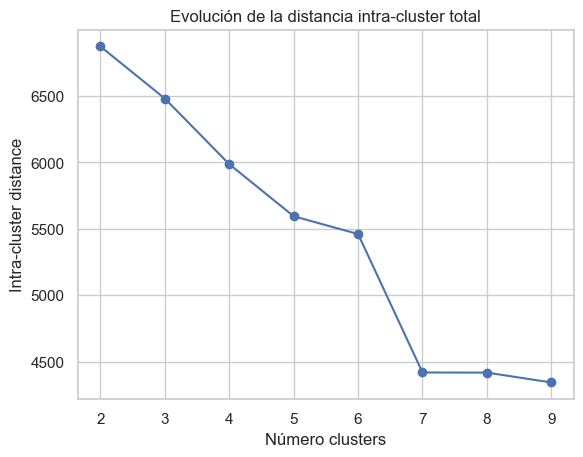

In [86]:
plt.plot(range_n_clusters, cost, marker='o')
plt.title("Evolución de la distancia intra-cluster total")
plt.xlabel('Número clusters')
plt.ylabel('Intra-cluster distance')

## Ajustamos K Modes

In [87]:
kmodes = KModes(n_clusters=4)
kmodes_model = kmodes.fit(engrana_cust) # lo ajustamos sobre los datos

### Interpretación de los clusters

In [88]:
engrana_modif['cluster'] = kmodes_model.labels_ # creamos columna que indique el cluster asignado a cada empleado

In [89]:
engrana_modif.head()

,base,servicio,grado_cargo,polivalencia_pax,region,cluster
0,ADZ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,MULTIAEROLINEA,San Andrés y Providencia,0
2,CTG,SV,AUXILIAR DE SERVICIOS,MULTIAEROLINEA,Costa Caribe,3
3,BAQ,SV,AUXILIAR DE SERVICIOS,MULTIAEROLINEA,Costa Caribe,3
4,MDE,SV,AUXILIAR DE SERVICIOS,MULTIAEROLINEA,Región Andina,1
5,MDE,SV,AUXILIAR DE SERVICIOS,MULTIAEROLINEA,Región Andina,1


In [90]:
engrana_modif['cluster'].value_counts()

cluster
0    2928
1    1555
3     360
2     259
Name: count, dtype: int64

In [91]:
freq_table = pd.crosstab(engrana_modif['cluster'], engrana_modif['region'], normalize='index') * 100

In [92]:
freq_table

region,Amazonía/Orinoquía,Costa Caribe,Región Andina,Región Sur,San Andrés y Providencia
cluster,,,,,
0,2.971311,19.842896,69.808743,0.648907,6.728142
1,2.122186,6.173633,80.707395,0.128617,10.868167
2,1.158301,0.000000,77.992278,0.000000,20.849421
3,0.000000,100.000000,0.000000,0.000000,0.000000


In [93]:
freq_table.reset_index().melt(id_vars=['cluster'], var_name=col, value_name='percentage')

,cluster,region,percentage
0,0,Amazonía/Orinoquía,2.971311
1,1,Amazonía/Orinoquía,2.122186
2,2,Amazonía/Orinoquía,1.158301
3,3,Amazonía/Orinoquía,0.000000
4,0,Costa Caribe,19.842896
5,1,Costa Caribe,6.173633
6,2,Costa Caribe,0.000000
7,3,Costa Caribe,100.000000
8,0,Región Andina,69.808743
9,1,Región Andina,80.707395


In [94]:
freq_table2 = pd.crosstab(engrana_modif['cluster'], engrana_modif['grado_cargo'], normalize='index') * 100

In [95]:
freq_table2

grado_cargo,ANFITRION DE SERVICIOS,AUXILIAR AT AVA CARGO,AUXILIAR AT DE LIMPIEZA,AUXILIAR DE ASISTENCIA EN TIERRA,AUXILIAR DE SERVICIO AL PASAJERO,AUXILIAR DE SERVICIOS,AUXILIAR DE SERVICIOS I,CONDUCTOR,CONDUCTOR EN FORMACION,CONDUCTOR ESPECIALIZADO,CONDUCTOR I,CONDUCTOR PAX,COORDINADORA SERVICIOS,INSTRUCTOR,LIDER CIO,LIDER DE ASISTENCIA EN TIERRA,LIDER DE SERVICIO AL PASAJERO,LIDER DE SERVICIOS,LIDER DE SERVICIOS I,LIDER DE SIG & SMS
cluster,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.102459,3.278689,92.247268,0.000000,0.000000,0.000000,0.170765,0.068306,3.073770,0.478142,0.068306,0.000000,0.000000,0.000000,0.478142,0.000000,0.000000,0.000000,0.034153
1,2.379421,0.000000,0.000000,0.000000,1.221865,90.932476,1.736334,0.000000,0.000000,0.000000,0.000000,0.000000,0.257235,0.064309,0.000000,0.000000,0.000000,3.344051,0.064309,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,90.347490,1.544402,0.000000,0.000000,0.000000,0.000000,0.000000,0.772201,0.000000,0.000000,0.000000,0.000000,6.949807,0.386100,0.000000
3,0.000000,0.000000,2.777778,0.277778,3.611111,80.833333,1.388889,0.277778,0.000000,6.111111,0.000000,0.000000,0.000000,0.000000,0.277778,0.555556,0.277778,3.333333,0.277778,0.000000


In [96]:
freq_table3 = pd.crosstab(engrana_modif['cluster'], engrana_modif['servicio'], normalize='index') * 100

In [97]:
freq_table3

servicio,AT,SV
cluster,,
0,100.000000,0.000000
1,0.064309,99.935691
2,0.000000,100.000000
3,10.000000,90.000000


In [98]:
freq_table4 = pd.crosstab(engrana_modif['cluster'], engrana_modif['polivalencia_pax'], normalize='index') * 100

In [99]:
freq_table4

polivalencia_pax,AEROLINEAS ARGENTINAS,AEROMEXICO,ARAJET,AVIANCA,AVIANCA EXPRESS,COPA,JETSMART,LATAM,MULTIAEROLINEA,SARPA,VIVA AIR,WINGO
cluster,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000
1,0.707395,0.514469,0.450161,1.350482,0.192926,9.903537,5.144695,13.954984,4.115756,0.450161,62.379421,0.836013
2,0.000000,0.000000,0.000000,0.000000,0.000000,15.444015,9.266409,1.930502,73.359073,0.000000,0.000000,0.000000
3,0.000000,0.000000,3.333333,1.944444,0.000000,18.888889,15.000000,3.888889,27.500000,0.555556,25.000000,3.888889


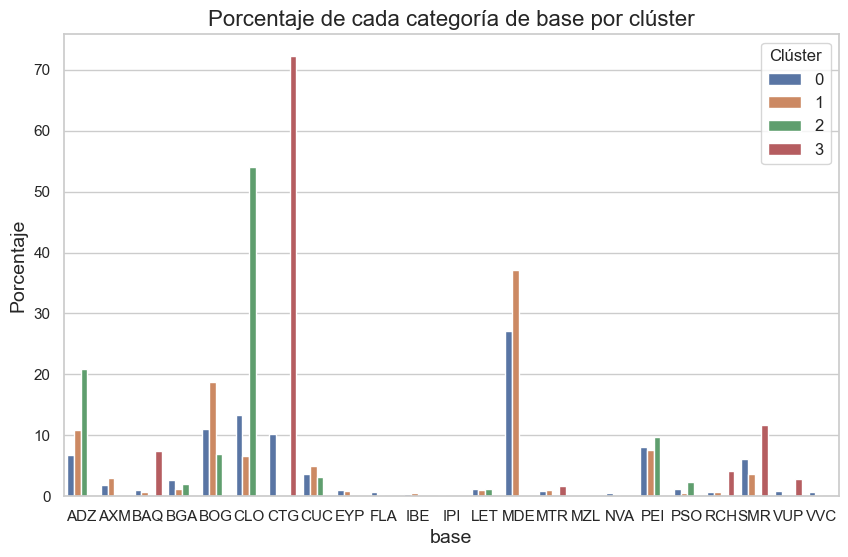

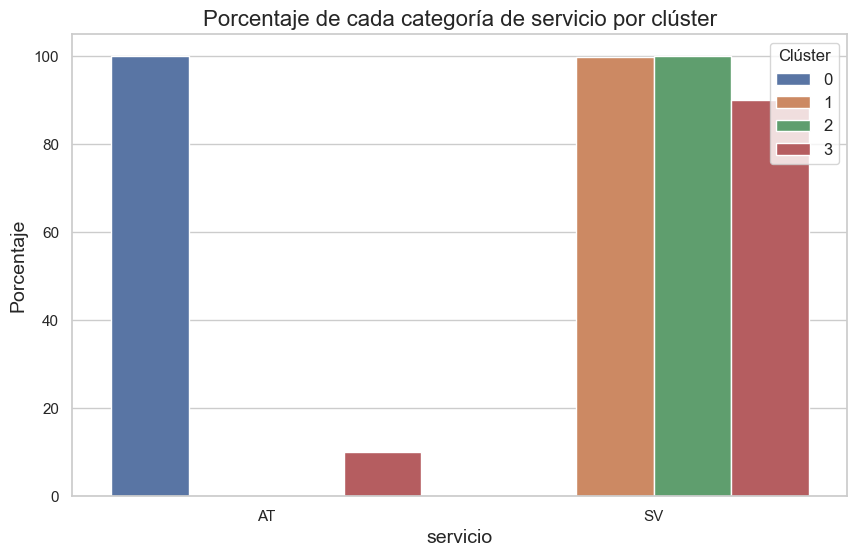

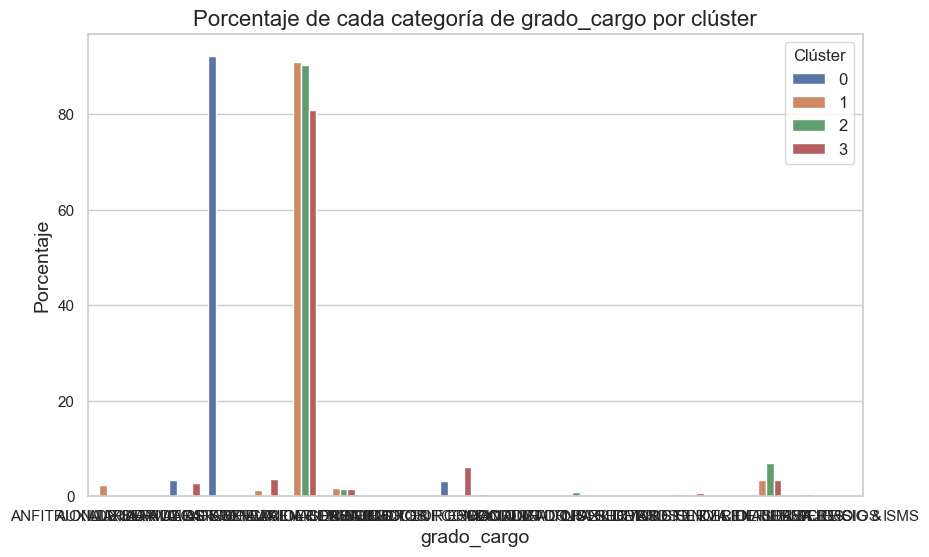

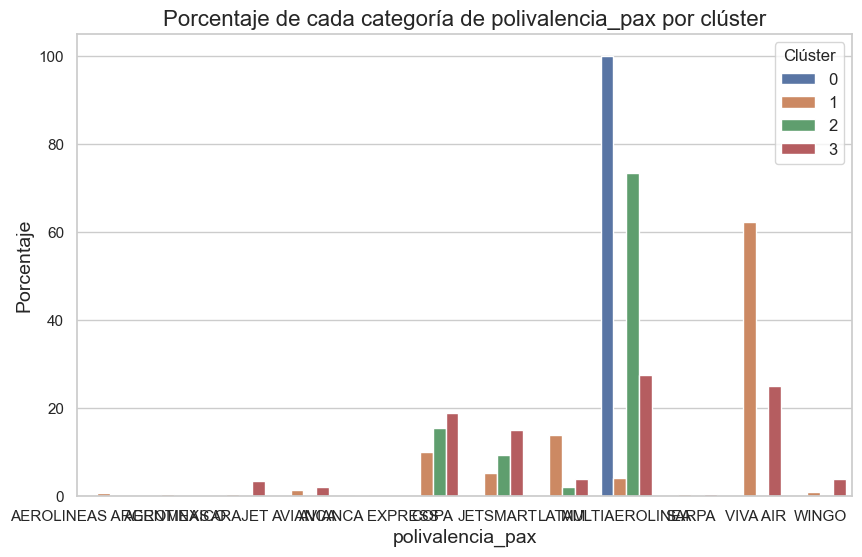

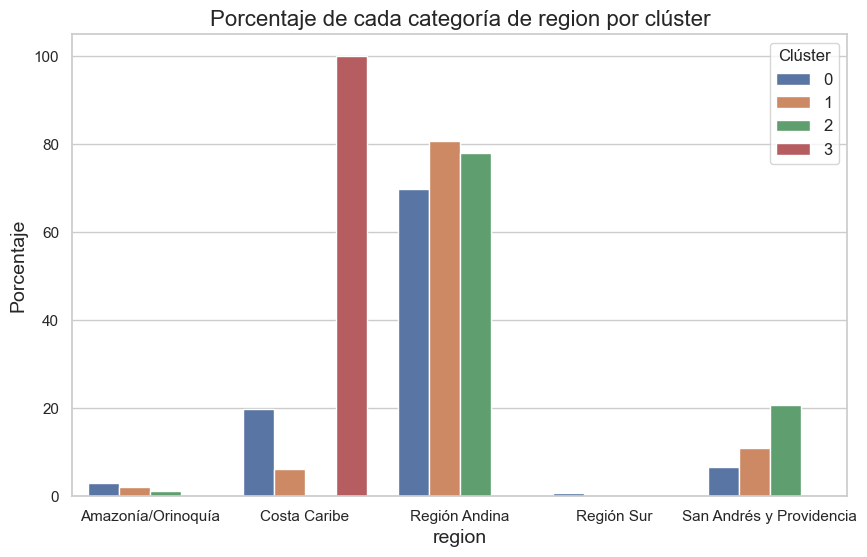

In [100]:
sns.set(style="whitegrid")  # Estilo del gráfico

for col in engrana_modif.columns[:-1]:
    
    plt.figure(figsize=(10, 6))
    
    freq_table = pd.crosstab(engrana_modif['cluster'], engrana_modif[col], normalize='index') * 100
    freq_table_long = freq_table.reset_index().melt(id_vars=['cluster'], var_name=col, value_name='percentage')
    
    # Crear gráfico de barras
    freq_table_long['cluster'] = freq_table_long['cluster'].astype(str)
    sns.barplot(x=col, y='percentage', hue='cluster', data=freq_table_long)
    
    # Personalizar el gráfico
    plt.title(f'Porcentaje de cada categoría de {col} por clúster', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Porcentaje', fontsize=14)
    plt.legend(title='Clúster', loc='upper right', fontsize=12)
    
    # Mostrar el gráfico
    plt.show()

Cluster_0:
Cluster_1:
Cluster_2:
Cluster_3: 